# Multiclassifier

Agora vamos ter 3 classes

> Pacientes Controle, Parkinson em estágio avançado, Parkinson em estágio inicial

In [1]:
%load_ext autoreload

In [14]:
import parkinson
import torch

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from torch import nn
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

--------------


### Leitura dos Dados

In [3]:
parkinson_data = parkinson.utils.data.batch_read('../data/PDs_columns')
control_data = parkinson.utils.data.batch_read('../data/Controls_columns')
prodomal_data = parkinson.utils.data.batch_read('../data/Prodomals_columns')

100%|██████████| 188/188 [00:09<00:00, 19.03it/s]


In [4]:
control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, 'AAL3')
parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, 'AAL3')
prodomal_atlas_data = parkinson.utils.data.select_atlas_columns(prodomal_data, 'AAL3')

parkinson_correlation_matrix = parkinson.utils.graph.compute_correlation_matrix(parkinson_atlas_data, "pearson")
control_correlation_matrix = parkinson.utils.graph.compute_correlation_matrix(control_atlas_data, "pearson")
prodomal_correlation_matrix = parkinson.utils.graph.compute_correlation_matrix(prodomal_atlas_data, "pearson")

X = np.concatenate([parkinson_correlation_matrix, prodomal_correlation_matrix, control_correlation_matrix], axis=0)
y = np.concatenate([
    [2 for _ in range(len(parkinson_data))],
    [1 for _ in range(len(prodomal_data))],
    [0 for _ in range(len(control_data))]
], axis=0)

X, y = parkinson.utils.data.filter_data(X, y)

-----------


### Hiperparâmetros

In [5]:
RANDOM_STATE = 50
N_SPLITS = 5  # Number of folds for cross-validation
TEST_SIZE = 0.2 # Hold-out test set size

# Model Hyperparameters
INPUT_DIM = X.shape[1] # Will be set after data loading
HIDDEN_DIM_1 = 32
HIDDEN_DIM_2 = 16
OUTPUT_DIM = 3
DROPOUT = 0.5

# Training Hyperparameters
NUM_EPOCHS = 150
BATCH_SIZE = 32
LEARNING_RATE = 0.001
PATIENCE = 2

----------

### Split dos dados

In [6]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.20, random_state=RANDOM_STATE, stratify=y_trainval, shuffle=True)

In [7]:
scaler = StandardScaler().fit(X_trainval)
X_trainval = scaler.transform(X_trainval)
X_test     = scaler.transform(X_test)

### Rede Neural Multiclasse

Network Multiclasse (`output_dim=3`)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = parkinson.NetworkModels.SimpleMLP(input_dim=X_train.shape[1], hidden_dim=16, output_dim=3)
class_weights = parkinson.utils.data.get_torch_class_weights(y_train)

In [9]:
test_loader = parkinson.utils.data.get_torch_dataloader(X_test, y_test, batch_size=BATCH_SIZE, shuffle=False)
train_loader = parkinson.utils.data.get_torch_dataloader(X_train, y_train, batch_size=BATCH_SIZE, shuffle=False)
val_loader = parkinson.utils.data.get_torch_dataloader(X_val, y_val, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
out = parkinson.utils.train.train(model, train_loader, val_loader, class_weights, device, num_epochs=NUM_EPOCHS, patience=5, lr=0.0001)

train-loss: 0.7180  train-acc: 0.8154 | val-loss: 0.9363  val-acc: 0.5385:  13%|█▎        | 19/150 [00:06<00:47,  2.78it/s]

Early stopping at epoch 20


In [11]:
model.eval()
y_pred_probabilities = model(torch.Tensor(X_test)).detach().numpy()
y_pred = np.argmax(y_pred_probabilities, axis=1)

In [12]:
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=['Control', 'Prodromal', 'Parkinson']))

              precision    recall  f1-score   support

     Control       0.25      0.31      0.28        13
   Prodromal       0.48      0.58      0.52        38
   Parkinson       0.60      0.39      0.47        31

    accuracy                           0.46        82
   macro avg       0.44      0.42      0.42        82
weighted avg       0.49      0.46      0.46        82



Podemos priorizar o Recall por classe para "Parkinson" e "Prodromal" para garantir que você não vamos perder nenhum caso real. O F1-Score pode ser usado para entender o balanço geral, mas seu objetivo principal é a identificação completa dos casos. A matriz de confusão é essencial para ver detalhadamente onde os erros estão ocorrendo.

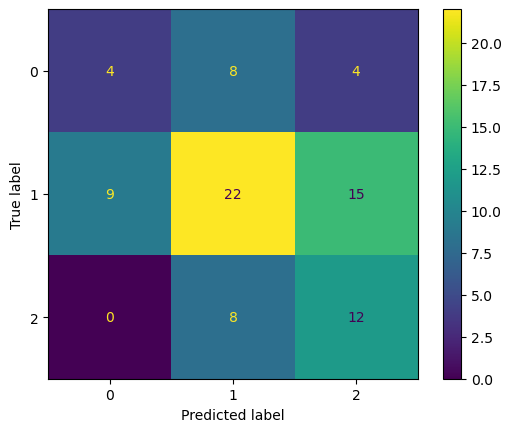

In [15]:
ConfusionMatrixDisplay.from_predictions(y_pred, y_test)